!["Movies"](Images\title.png)

# Flixnet Recommendation System

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import surprise
from surprise.prediction_algorithms import *
from surprise import accuracy, Dataset, Reader, BaselineOnly

from surprise.model_selection import cross_validate, train_test_split
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline, NMF
from surprise.model_selection import GridSearchCV


## Business Problem

Flixnet is a large movie streaming platform that draws in many users every day. We are tasked with creating an app that recommends movies based on user ratings for the 20 most rated films on the platform. Based on the rating of these 20 films, we use ML to test and build the best model that provides the top 5 movie recommendations. 

## Data Exploration

In [2]:
links_df = pd.read_csv('data/links.csv')
movies_df = pd.read_csv('data/movies.csv')
ratings_df = pd.read_csv('data/ratings.csv')
tags_df = pd.read_csv('data/tags.csv')

In [3]:
links_df.head()
movies_df.head()
ratings_df.head()
tags_df.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [4]:
links_df.info()
movies_df.info()
ratings_df.info()
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  fl

We are most intested in ratings_df as it contains all the relevant columns.

In [5]:
ratings_df.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [6]:
print("userIds", ratings_df['userId'].nunique())
print("movieIds", ratings_df['movieId'].nunique())

userIds 610
movieIds 9724


We have 610 unique users and 9724 different movies

In [7]:
ratings_df['timestamp']

0          964982703
1          964981247
2          964982224
3          964983815
4          964982931
             ...    
100831    1493848402
100832    1493850091
100833    1494273047
100834    1493846352
100835    1493846415
Name: timestamp, Length: 100836, dtype: int64

### Dealing with SuperUsers:



In [8]:
ratings_df['userId'].value_counts()

sp = ratings_df['userId'].value_counts()
sp

userId
414    2698
599    2478
474    2108
448    1864
274    1346
       ... 
442      20
569      20
320      20
576      20
53       20
Name: count, Length: 610, dtype: int64

Superusers are users who have reviewed more than 500 films. We choose this cut off based off of this histogram:

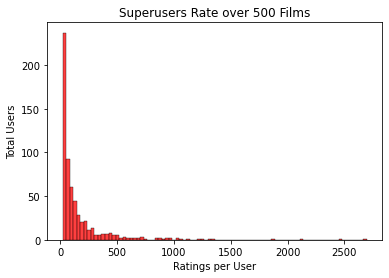

In [9]:
ax = sns.histplot(ratings_df["userId"].value_counts(), color="red", )
plt.xlabel('Ratings per User')
plt.ylabel('Total Users')
plt.title('Superusers Rate over 500 Films')
plt.show();

In [10]:
#this removes superusers from ratings_df
ratings_df_nosuper = ratings_df[ratings_df.groupby('userId')['userId'].transform('size') < 500]

In [11]:
ratings_df_nosuper['userId'].value_counts()

userId
57     476
381    474
368    469
509    467
469    465
      ... 
576     20
431     20
257     20
442     20
278     20
Name: count, Length: 566, dtype: int64

we now have ratings_df without superusers

## Data Processing for Modeling

We will be looking and modeling ratings_df, as it contains all the columns we are interested in.

In [12]:
ratings_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [13]:
ratings_df_nosuper

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
99529,609,892,3.0,847221080
99530,609,1056,3.0,847221080
99531,609,1059,3.0,847221054
99532,609,1150,4.0,847221054


In [14]:
#remove timestamp column, which is unnecessary for modeling
ratings_df = ratings_df.drop("timestamp", axis=1)
ratings_df

ratings_df_nosuper = ratings_df_nosuper.drop('timestamp', axis=1)
ratings_df_nosuper

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
99529,609,892,3.0
99530,609,1056,3.0
99531,609,1059,3.0
99532,609,1150,4.0


In [15]:
ratings_df_nosuper["userId"].nunique()

566

Transform dataset into suprise compatible data

In [16]:
from surprise import Reader, Dataset

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_df, reader)

In [17]:
full_dataset = data.build_full_trainset()

#view the number of users and items
print('Number of users: ', full_dataset.n_users, '\n')
print('Number of items: ', full_dataset.n_items)

Number of users:  610 

Number of items:  9724


Splitting Data into Data set A, for training, and B for testing:

In [18]:
## We use train_test_split

trainset, testset = train_test_split(data, test_size=0.2,random_state=42)

In [19]:
#function for outputting the accuracy predictions on an algorithm

def train_and_test_pred (algo, trainset, testset): 
    algo.fit(trainset)
   
    train_predictions = algo.test(trainset.build_testset())
    print('biased accuracy on train set: ')
    print(accuracy.rmse(train_predictions))
    print(accuracy.mae(train_predictions))
    test_predictions = algo.test(testset)
    print('unbiased accuracy on test set: ')
    print(accuracy.rmse(test_predictions))
    print(accuracy.mae(test_predictions))

## Determining the Best Model

Compare different models and determine which is the best. We will use RMSE to evaluate models.

### Baseline: 

Our baseline model will be KNNBasic, a basic collaborative filtering algorithm, with no parameters

In [20]:
baseline_model = KNNBasic()
train_and_test_pred(baseline_model, trainset, testset)

Computing the msd similarity matrix...
Done computing similarity matrix.
biased accuracy on train set: 
RMSE: 0.7110
0.710986894321433
MAE:  0.5316
0.5316262167615223
unbiased accuracy on test set: 
RMSE: 0.9561
0.9560731582415551
MAE:  0.7325
0.7325203978636554


In [21]:
#Scores for KNN Basic via cross validation
cv_knn_basic = cross_validate(baseline_model, data)
print("mean fit time", np.mean(cv_knn_basic['fit_time']))
print("mean test time", np.mean(cv_knn_basic['test_time']))
print("mean test rmse", np.mean(cv_knn_basic['test_rmse']))

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
mean fit time 0.15175867080688477
mean test time 1.4409749031066894
mean test rmse 0.9483885175380056


### SVD:

In [22]:
## Scores for Baseline SVD Crossvalidation

svd = SVD()
cv_svd = cross_validate(svd, data)
print("mean fit time", np.mean(cv_svd['fit_time']))
print("mean test time", np.mean(cv_svd['test_time']))
print("mean test rmse", np.mean(cv_svd['test_rmse']))


mean fit time 4.4486839294433596
mean test time 0.15134768486022948
mean test rmse 0.874729043033945


In [23]:
train_and_test_pred(svd, trainset, testset)

biased accuracy on train set: 
RMSE: 0.6404
0.640405507853731
MAE:  0.4970
0.4970452420426007
unbiased accuracy on test set: 
RMSE: 0.8828
0.8827637835963649
MAE:  0.6796
0.6795687863805928


In [24]:
# performing a gridsearch with SVD

params = {
    'n_factors': [100,150,200],
    'n_epochs': [20,80,100],
    'lr_all': [0.008,0.01],
    'reg_all': [0.07,0.1]
}

SVD_grid = GridSearchCV(SVD, param_grid = params, cv=5)
SVD_grid.fit(data)

In [ ]:
#view grid search results
print(SVD_grid.best_params)
print(SVD_grid.best_score)

In [ ]:
## choose the best algo
svd_best_algo = SVD_grid.best_estimator['rmse']

In [ ]:
# Use our function to output train/test predictions
train_and_test_pred(svd_best_algo, trainset, testset)

In [ ]:
#Scores for Best SVD via cross validation
cv_best_svd = cross_validate(svd_best_algo, data)
print("mean fit time", np.mean(cv_best_svd['fit_time']))
print("mean test time", np.mean(cv_best_svd['test_time']))
print("mean test rmse", np.mean(cv_best_svd['test_rmse']))

### KNNBasic:

In [ ]:
## Scores for Baseline KNNBasic Crossvalidation

knn_basic = KNNBasic(sim_options={"name": 'pearson', 'user_based':True})
cv_knn_basic = cross_validate(knn_basic, data, n_jobs=-1)
print("mean fit time", np.mean(cv_knn_basic['fit_time']))
print("mean test time", np.mean(cv_knn_basic['test_time']))
print("mean test rmse", np.mean(cv_knn_basic['test_rmse']))

In [ ]:
train_and_test_pred(knn_basic, trainset, testset)

In [ ]:
## GridSearch with KNNBasic
## note: this takes several minutes to run
params = {
    'k': [20,40,60],
    'sim_options': {
        'name':['msd', 'cosine', 'pearson'],
        'user_based': [True,False]   
    }
}
KNNBasic_grid = GridSearchCV(KNNBasic, param_grid = params, cv=5)
KNNBasic_grid.fit(data)

In [ ]:
#view grid search results
print(KNNBasic_grid.best_params)
print(KNNBasic_grid.best_score)

In [ ]:
#take the best model and 
#test on train/test 
KNNbasic_best_algo = KNNBasic_grid.best_estimator['rmse']
train_and_test_pred(KNNbasic_best_algo, trainset, testset)

In [ ]:
#Scores for Best KNNbasic via cross validation
cv_best_knnbasic = cross_validate(KNNbasic_best_algo, data)
print("mean fit time", np.mean(cv_best_knnbasic['fit_time']))
print("mean test time", np.mean(cv_best_knnbasic['test_time']))
print("mean test rmse", np.mean(cv_best_knnbasic['test_rmse']))

### KNNBaseline

In [ ]:
##view our cross validation score with KNNBaseline:
knn_baseline = KNNBaseline(sim_options={"name": 'pearson', 'user_based':True})
cv_knn_baseline = cross_validate(knn_baseline, data)
print("mean fit time", np.mean(cv_knn_baseline['fit_time']))
print("mean test time", np.mean(cv_knn_baseline['test_time']))
print("mean test rmse", np.mean(cv_knn_baseline['test_rmse']))

In [ ]:
## now view our accuracy with train/test data
train_and_test_pred(knn_baseline, trainset, testset)

In [ ]:
## GridSearch with KNNBaseline
## note: this takes several minutes to run
params = {
    'k': [10,20,40,50],
    'sim_options': {
        'name':['msd', 'cosine', 'pearson'],
    },
    'bsl_options': {
        "method": ["als","sgd"],
        'reg': [0.02,0.5, 1, 2],
        'n_epochs': [20,40]
    }
}
KNNBaseline_grid = GridSearchCV(KNNBaseline, param_grid = params, cv=5)
KNNBaseline_grid.fit(data)

In [ ]:
#view grid search results
print(KNNBaseline_grid.best_params)
print(KNNBaseline_grid.best_score)

In [ ]:
#take the best model and 
#test on train/test 
KNNbaseline_best_algo = KNNBaseline_grid.best_estimator['rmse']
train_and_test_pred(KNNbaseline_best_algo, trainset, testset)

In [ ]:
#Scores for Best KNN Baseline via cross validation
cv_best_knnbaseline = cross_validate(KNNbaseline_best_algo, data)
print("mean fit time", np.mean(cv_best_knnbaseline['fit_time']))
print("mean test time", np.mean(cv_best_knnbaseline['test_time']))
print("mean test rmse", np.mean(cv_best_knnbaseline['test_rmse']))

### NMF

In [ ]:
#Baseline NMF cross validation scores
nmf = NMF()

cv_nmf = cross_validate(nmf, data)
print("mean fit time", np.mean(cv_nmf['fit_time']))
print("mean test time", np.mean(cv_nmf['test_time']))
print("mean test rmse", np.mean(cv_nmf['test_rmse']))

In [ ]:
## GridSearch with NMF
## note: this takes several minutes to run
params = {
    'n_factors': [10,15,20,25,30],
    "n_epochs": [25,50,75,100],
    "biased": [True,False],
    "reg_pu": [0.06,0.1],
    "reg_qi": [0.06,0.1]
}
nmf_grid = GridSearchCV(NMF, param_grid = params, cv=5)
nmf_grid.fit(data)

In [ ]:
#view grid search results
print(nmf_grid.best_params)
print(nmf_grid.best_score)

In [ ]:
#take the best model and 
#test on train/test 
nmf_best = nmf_grid.best_estimator['rmse']
train_and_test_pred(nmf_best, trainset, testset)

In [ ]:
#Scores for Best NMF via cross validation
cv_best_nmf = cross_validate(nmf_best, data)
print("mean fit time", np.mean(cv_best_nmf['fit_time']))
print("mean test time", np.mean(cv_best_nmf['test_time']))
print("mean test rmse", np.mean(cv_best_nmf['test_rmse']))


In [ ]:
## Best model so far: 
# NMF rmse: 0.8774 {'n_factors': 10, 'n_epochs': 50, 'biased': True, 'reg_pu': 0.1, 'reg_qi': 0.1}, 
# NMF'mae': 0.7698 {'n_factors': 10, 'n_epochs': 100, 'biased': True, 'reg_pu': 0.1, 'reg_qi': 0.1}}
#SVD: 0.8633 'rmse': {'n_factors': 200, 'n_epochs': 80, 'lr_all': 0.01, 'reg_all': 0.1}, 
#SVD: 0.7453 'mae': {'n_factors': 150, 'n_epochs': 100, 'lr_all': 0.01, 'reg_all': 0.1}}

### Comparing Models:

In [ ]:
models_df = pd.DataFrame()
models_df['modelId'] = ['KNNBasic', "KNNBaseline", "NMF", "SVD"]
models_df['RMSE'] = [0.988, 0.866, 0.878, 0.863]

##runtime for models:
KNNBasic_runtime = np.mean(cv_knn_basic['fit_time'])+np.mean(cv_knn_basic['test_time'])
print("KNNBasic runtime", KNNBasic_runtime)

KNNBaseline_runtime = np.mean(cv_best_knnbaseline['fit_time'])+np.mean(cv_best_knnbaseline['test_time'])
print("KNNBaseline runtime", KNNBaseline_runtime)

nmf_runtime = np.mean(cv_best_nmf['fit_time'])+np.mean(cv_best_nmf['test_time'])
print("NMF runtime", nmf_runtime)

svd_runtime = np.mean(cv_best_svd['fit_time'])+np.mean(cv_best_svd['test_time'])
print("SVD runtime", svd_runtime)

models_df['runTime'] = [KNNBasic_runtime, KNNBaseline_runtime, nmf_runtime, svd_runtime]

models_df

## Making Recommendations

We want to return the actual title of a movie instead of an ID

In [ ]:
movies_df.head()

### Making simple predictions

Taking our best algorithm so far: SVD

In [ ]:
best_algo = SVD(n_factors= 200, n_epochs= 80, lr_all= 0.01, reg_all= 0.1)
best_algo.fit(trainset)

In [ ]:
best_algo.test(testset)
accuracy.rmse(best_algo.test(testset))

### Obtaining User Rankings

Creating a function that allows the current user to rate movies in our database. The function will save the ratings of the current user and give recommendations based on their preferences.

The function `movie_rater()` takes as parameters: 

* `movie_df`: DataFrame - a dataframe containing the movie ids, name of movie, and genres
* `num`: int - number of ratings
* `genre`: string - a specific genre from which to draw movies

The function returns:
* rating_list : list - a collection of dictionaries in the format of {'userId': int , 'movieId': int , 'rating': float}

In [ ]:
def movie_rater(movie_df,num, genre=None):
    userId = 1000
    rating_list = []
    
    while num > 0:    
        if genre:
            movie = movie_df[movie_df['genres'].str.contains(genre)].sample(1)
        else:
            movie = movie_df.sample(1)
            
        print(movie)
        rating = input("Please rate this movie from 1-5, press n if you have not seen :\n")
    
        try: 
            if 1 <= int(rating) <= 5:
                rating_movie = {'userId': userId, "movieId":movie['movieId'].values[0], "rating": rating}
                rating_list.append(rating_movie)
                num -= 1
        except:
            print('Please enter a valid rating from 1-5')
            continue
    return rating_list


In [ ]:
movies_df.loc[movies_df["movieId"]==663]

In [ ]:
## Trying out the function:
user_rating = movie_rater(movies_df, 5, "Comedy")
user_rating

### Making Predictions with the New Ratings

In [ ]:
user_rating

In [ ]:
movie_list20 = [ 356,  318,  296,  593, 2571,  260,  480,  110,  589,  527, 2959, 1, 1196, 2858,   50,   47,  780,  150, 1198, 4993]

In [ ]:
sorted(movie_list20)

In [ ]:
## add the new ratings to the original ratings DataFrame
user_ratings_df = pd.DataFrame(user_rating)
ratings_df = pd.concat([ratings_df, user_ratings_df], axis=0)
new_data = Dataset.load_from_df(ratings_df, reader)

In [ ]:
# make predictions for the user
# tuples in the format (movie_id, predicted_score)
recc_movies = []
for m_id in ratings_df['movieId'].unique():
    if (m_id in movie_list20): 
        continue
    else:
        prediction = best_algo.predict(1000,m_id)[3]
        recc_movies.append( (m_id, prediction) )

In [ ]:
# order the predictions from highest to lowest rated

ranked_movies = sorted(recc_movies, key=lambda x:x[1], reverse = True)

In [ ]:
ranked_movies

We create a function `recommended_movies()` that takes in the parameters:
* `user_ratings`: list - list of tuples formulated as (user_id, movie_id) (should be in order of best to worst for this individual)
* `movie_title_df`: DataFrame 
* `n`: int - number of recommended movies 

We print out each recommended *n* movies in order from best to worst

In [ ]:
# return the top n recommendations
def recommended_movies(user_ratings,movie_title_df,n):
    for idx, rec in enumerate(user_ratings):
        title = movie_title_df.loc[movie_title_df['movieId'] == int(rec[0])]['title']
        print('Recommendation # ', idx+1, ': ', title.values[0], '\n')
        n-= 1
        if n == 0:
            break

In [ ]:
recommended_movies(ranked_movies, movies_df, 5)

Combining all into one function:

In [ ]:
def rate_and_rec(ratings_df, movies_df,num, genre=None):
        
    user_rating = movie_rater(movies_df, num, genre)
    
    ## add the new ratings to the original ratings DataFrame
    user_ratings_df = pd.DataFrame(user_rating)
    ratings_df = pd.concat([ratings_df, user_ratings_df], axis=0)
    
    new_data = Dataset.load_from_df(ratings_df, reader)
    best_algo = SVD(n_factors= 200, n_epochs= 80, lr_all= 0.01, reg_all= 0.1)
    best_algo.fit(new_data.build_full_trainset())

    # make predictions for the user
    # create a list of tuples in the format (movie_id, predicted_score)
    recc_movies = []
    for m_id in ratings_df['movieId'].unique():
        prediction = best_algo.predict(1000,m_id)[3]
        recc_movies.append( (m_id, prediction) )
    
    # order the predictions from highest to lowest rated
    ranked_movies = sorted(recc_movies, key=lambda x:x[1], reverse = True)
    
    recommended_movies(ranked_movies,movies_df,5)

In [ ]:
rate_and_rec(ratings_df, movies_df, 5, None)

Check out the app code [here.](web_app.py)